In [1]:
%config IPCompleter.greedy=True

In [2]:
import sys
import os
import pandas as pd
sys.path.append("..") # relative path to module toolkit

In [3]:
from keras.models import Model, load_model
from keras_preprocessing.image import ImageDataGenerator
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


tf.estimator package not installed.
tf.estimator package not installed.


In [4]:
# setup
batch_size = 1
val_dir = "./val_segmented/Backgrounds/"
val_images = 3111
datasetDir = "images_genus/"
saved_model = '../resNet50_pretrained/restnet50pretrained.h5'
results_file = "results_noBeetles.csv"

In [5]:
labels = getLabelsFromDir(val_dir)
val_datagen = ImageDataGenerator(rescale=1./255.)
validation_steps = int(val_images/batch_size) 

In [6]:
model = load_model(saved_model)

In [7]:
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=False,
                                                    seed=1)

Found 3111 images belonging to 44 classes.


In [8]:
Y_pred = model.predict_generator(val_generator, steps=validation_steps, verbose=1)

3111/3111 [==============================] - 78s 25ms/step


In [9]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred3 = [y[-3:] for y in np.argsort(Y_pred, axis=1)] 

In [10]:
print(classification_report(val_generator.classes, y_pred, target_names=labels))

              precision    recall  f1-score   support

  Lobrathium       0.00      0.00      0.00        22
    Achenium       0.00      0.00      0.00         8
 Acylophorus       0.00      0.00      0.00        20
     Astenus       0.00      0.00      0.00       115
     Atrecus       0.10      0.07      0.08        14
     Bisnius       0.22      0.03      0.06       176
      Cafius       0.00      0.00      0.00        57
  Creophilus       0.00      0.00      0.00         7
Dinothenarus       0.00      0.00      0.00         8
        Emus       0.00      0.00      0.00         4
 Erichsonius       0.00      0.00      0.00        36
   Euryporus       0.00      0.00      0.00         8
     Gabrius       0.00      0.00      0.00       114
  Gabronthus       0.00      0.00      0.00         5
 Gauropterus       0.00      0.00      0.00        12
  Gyrohypnus       0.00      0.00      0.00        51
 Heterothops       0.00      0.00      0.00        60
  Lathrobium       0.00    

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Normalized confusion matrix
[[ 0.          0.          0.         ...,  0.18181818  0.          0.        ]
 [ 0.          0.          0.         ...,  0.375       0.          0.        ]
 [ 0.          0.          0.         ...,  0.05        0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.5         0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.01960784  0.          0.        ]]


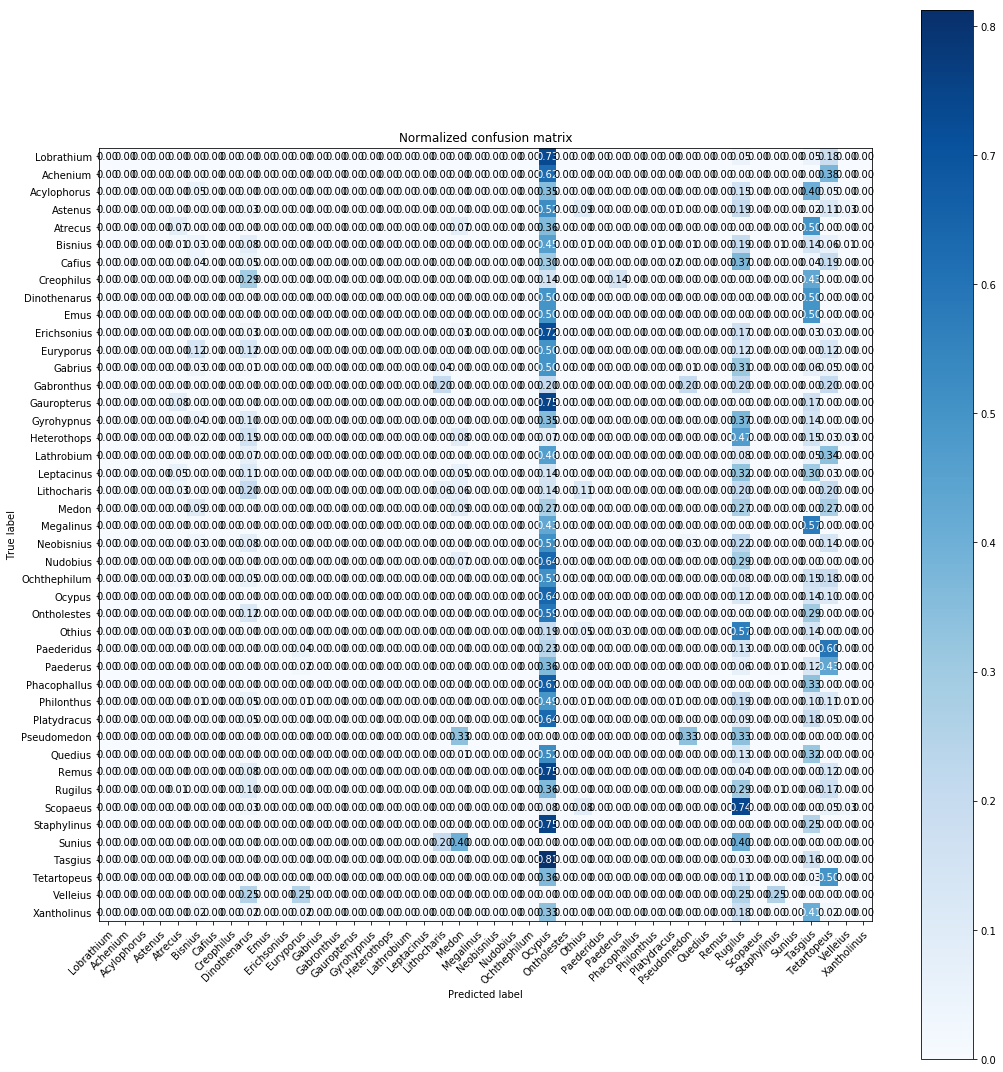

In [13]:
y_true = val_generator.classes
matplotlib.rcParams['figure.figsize'] = [15, 15]
plot_confusion_matrix(y_true, y_pred, np.array(labels), normalize=True)

In [14]:
labels = (val_generator.class_indices) # dict of label:index
labels = dict((i,l) for l,i in labels.items()) # dict of index:label

In [15]:
# create pd.dataframe and save predictions to .csv
filenames=[datasetDir + name for name in val_generator.filenames]
y_pred_labels = [labels[y] for y in y_pred]
y_true_labels = [labels[y] for y in y_true]
y_pred3_labels = []
for i,top3 in enumerate(y_pred3):
    l = []
    for top in top3:
        l.append((labels[top], Y_pred[i][top]))
    y_pred3_labels.append(l)

results=pd.DataFrame({"Filename":filenames,
                      "Label":y_true_labels,
                      "Prediction1":y_pred_labels,
                      "Prediction3":y_pred3_labels})
results.to_csv(results_file,index=True)